In [1]:
import numpy as np

import datetime
import io
import os
import random

import matplotlib.pyplot as plt

from sklearn.neighbors.kde import KernelDensity

%matplotlib inline

In [2]:
%run ../crowd/data.py
%run ../crowd/config.py
%run ../crowd/file_util.py
%run ../crowd/graph.py
%run ../crowd/topic.py

In [3]:
id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
test_data = read_all_test_labels()

In [4]:
def cosine_sims(topic_id):
    # Currently unused.
    fulltext_folder = FULLTEXT_FOLDER
    _, corpus = get_topic_files(fulltext_folder, topic_id)

    vectorizer = TfidfVectorizer(min_df=1)
    term_doc_matrix = vectorizer.fit_transform([text for doc_id, text in corpus])
    similarities = cosine_similarity(term_doc_matrix)
    flat_sim = similarities.reshape((-1, 1))
    flat_sim.shape

In [5]:
def count_votes(votes):
    relevant_votes = 0
    non_relevant_votes = 0
    for vote in votes:
        if vote.is_relevant > 0:
            relevant_votes += 1
        else:
            non_relevant_votes += 1
    
    return relevant_votes, non_relevant_votes


def get_vote_results(topic_id, judgements):
    judgements_by_doc_id = get_topic_judgements_by_doc_id(topic_id, judgements)
    vote_relevant = set()
    vote_non_relevant = set()
    for doc_id, judgements in judgements_by_doc_id.items():
        rel_votes, non_rel_votes = count_votes(judgements)
        if rel_votes > non_rel_votes:
            vote_relevant.add(doc_id)
        elif rel_votes < non_rel_votes:
            vote_non_relevant.add(doc_id)
            
    return vote_relevant, vote_non_relevant

(80, 80)
(31, 31)


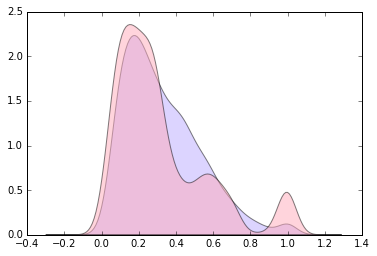

In [9]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

options={"[%s] %s (%d)" % (t.topic_id, t.query, t.document_count) : t.topic_id for t in id_topic_info.values()}

@interact(topic_id=options)
def topic_sim_kde(topic_id):
    gt_relevant, gt_non_relevant = get_relevant(topic_id, test_data)
    vote_relevant, vote_non_relevant = get_vote_results(topic_id, judgements)
    _, corpus = get_topic_files(FULLTEXT_FOLDER, topic_id)

    vectorizer = TfidfVectorizer(min_df=1)
    gt_rel_term_doc_matrix = vectorizer.fit_transform([text for doc_id, text in corpus if doc_id in gt_relevant or doc_id in vote_relevant])
    gt_non_rel_term_doc_matrix = vectorizer.fit_transform([text for doc_id, text in corpus if doc_id in gt_non_relevant or doc_id in vote_non_relevant])
    gt_rel_similarities = cosine_similarity(gt_rel_term_doc_matrix)
    gt_non_rel_similarities = cosine_similarity(gt_non_rel_term_doc_matrix)
    print(gt_rel_similarities.shape)
    print(gt_non_rel_similarities.shape)
    
    bandwidth = 0.05
    X_plot = np.arange(-0.3, 1.3, 0.01).reshape(-1, 1)
    #kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(flat_sim)
    #log_dens = kde.score_samples(X_plot)

    flat_gt_rel = gt_rel_similarities.reshape(-1, 1)
    kde_inner = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(flat_gt_rel)
    log_dens_inner = kde_inner.score_samples(X_plot)

    flat_gt_non_rel = gt_non_rel_similarities.reshape(-1, 1)
    kde_outer = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(flat_gt_non_rel)
    log_dens_outer = kde_outer.score_samples(X_plot)

    #plt.hist(flat_sim, bins=15, color="green", alpha=0.5, normed=True)
    #plt.fill(X_plot, np.exp(log_dens), fc='#AAAAFF', alpha=0.5)
    #plt.title("Gaussian Kernel Density")

    plt.fill(X_plot, np.exp(log_dens_inner), fc='#BBAAFF', alpha=0.5)
    plt.fill(X_plot, np.exp(log_dens_outer), fc='#FFAABB', alpha=0.5)